In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics

matplotlib.get_backend()
%matplotlib inline
train = pd.read_csv("Train.csv")
Train_AccountInfo = pd.read_csv("Train_AccountInfo.csv")
Train_Demographics = pd.read_csv("Train_Demographics.csv")
Train_ServicesOptedFor = pd.read_csv("Train_ServicesOptedFor.csv")

In [2]:
print(train.shape)
train.head()

(5298, 2)


,CustomerID,Churn
0,Cust4327,Yes
1,Cust3826,No
2,Cust6200,No
3,Cust1467,No
4,Cust4843,No


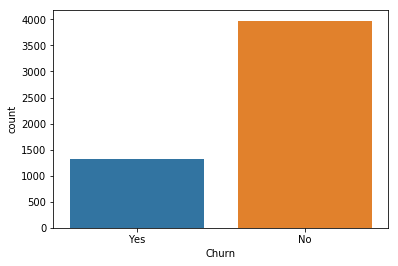

In [3]:
sns.countplot(x="Churn", data=train)
#the data is highly imbalanced..

In [4]:
print(Train_AccountInfo.shape)
Train_AccountInfo.head()

(5298, 8)


,CustomerID,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod
0,Cust1450,417.75,5-1-2012,3400.25,10-May-11,Yes,Month-to-month,Electronic check
1,Cust4452,500.00,5-1-2012,7673.75,12-Sep-10,Yes,Month-to-month,Electronic check
2,Cust1681,394.00,5-1-2012,8206.5,15-May-10,No,Month-to-month,Electronic check
3,Cust4761,398.75,5-1-2012,5559.25,12-Oct-10,Yes,Month-to-month,Electronic check
4,Cust1785,447.25,5-1-2012,4265.5,10-Apr-11,No,Month-to-month,Electronic check


In [5]:
#taking the first record in train_accounntinfo and checking in train data to know wheeather to merge or not
train[train.CustomerID == "Cust1450"]

,CustomerID,Churn
3817,Cust1450,Yes


In [6]:
#merging two dataframes with customerid attribute
train_train_account= pd.merge(Train_AccountInfo,train,on="CustomerID")
train_train_account[train_train_account.CustomerID == "Cust1450"] #checking the merged dataframe

,CustomerID,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust1450,417.75,5-1-2012,3400.25,10-May-11,Yes,Month-to-month,Electronic check,Yes


In [7]:
print(Train_Demographics.shape)
Train_Demographics.head()
Train_Demographics[Train_Demographics.HouseholdID == "Cust1450"]

(5298, 8)


,HouseholdID,Country,State,Retired,HasPartner,HasDependents,Education,Gender
453,Cust1450,India,Maharashtra,0,1,1,Highschool or below,Female


In [8]:
#renaming a column to match
Train_Demographics = Train_Demographics.rename(columns={ "HouseholdID" : "CustomerID"})
#Train_Demographics['HouseholdID'] = "CustomerID"
train_account_demo = pd.merge(Train_Demographics,train_train_account, on="CustomerID")
train_account_demo.head(2)

,CustomerID,Country,State,Retired,HasPartner,HasDependents,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust5390,India,Maharashtra,0,2,2,Graduation,Female,106.0,5-1-2012,1113.25,11-Mar-11,Yes,Month-to-month,Electronic check,No
1,Cust4417,India,Maharashtra,1,1,2,Highschool or below,Male,473.0,5-1-2012,1397.75,7-Oct-11,Yes,Month-to-month,Electronic check,Yes


In [9]:
#the services opted by different users is different
#lets replace the values where the customer did not subscribe with NO
#replace values where the customer subscribed with YES
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "1"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "No internet service"] = "No"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "0"] = "No"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "Fiber optic"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "DSL"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "No phone service"] = "No"
#Train_ServicesOptedFor[Train_ServicesOptedFor.CustomerID == "Cust1450"]

In [10]:
#remove records that have NO and the we will have the services that each customer has chosen
#now lets dummify those services 
yes_train_service = Train_ServicesOptedFor[Train_ServicesOptedFor.SeviceDetails != 'No']
yes_train_service = yes_train_service.sort_values(by=['TypeOfService'], ascending=['True'])
ff = pd.get_dummies(yes_train_service, prefix=['TypeOfService'],
               columns=['TypeOfService'])

In [11]:
## we have multiple records with same customer id as a customer minght be sbscribed to many services
#hence adding the multiple rows to single rows
xx = ff.groupby('CustomerID')['SeviceDetails'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
xx.columns = xx.columns.droplevel()
xx.columns = ['CustomerID','TypeOfService_DeviceProtection', 'TypeOfService_HasPhoneService', 
              'TypeOfService_InternetServiceCategory','TypeOfService_StreamingMovies','TypeOfService_StreamingTelevision',
              'TypeOfService_OnlineBackup','TypeOfService_OnlineSecurity',
             'TypeOfService_MultipleLines',
              'TypeOfService_TechnicalSupport']
xx = xx.replace({'Yes': 1, None: 0})
train_account_demo = pd.merge(xx,train_account_demo, on="CustomerID",how='inner')
train_account_demo.head(2) #we have dummified dataset with 1 in the service customer subscribed

,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust1201,1,1,1,1,1,0,0,0,0,...,Masters,Male,478.50,5-1-2012,5920,10-Jan-11,No,One year,Electronic check,No
1,Cust1202,1,0,0,0,0,0,0,0,0,...,ProfessionalQalification,Male,103.25,5-1-2012,103.25,6-Dec-11,No,Month-to-month,Electronic check,No


## Visualization

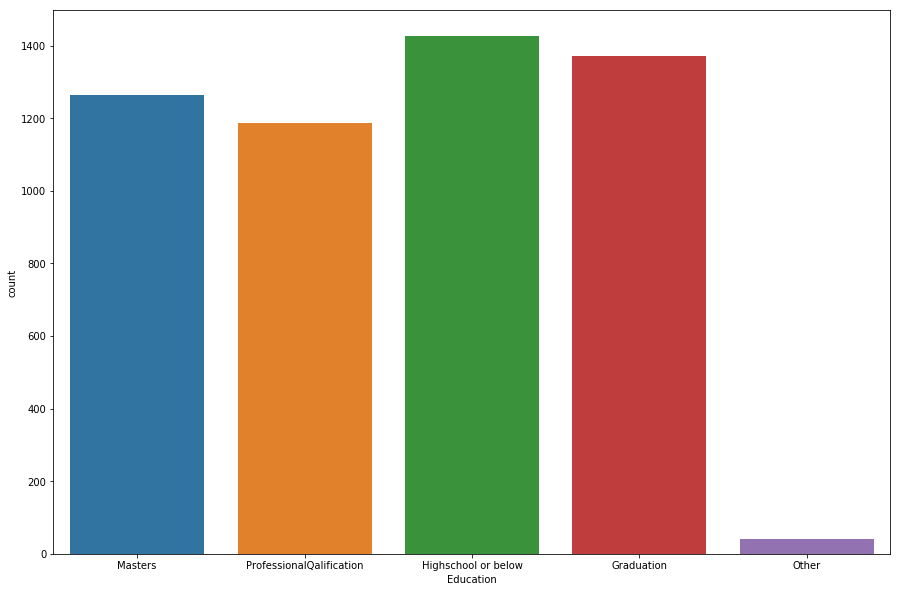

In [12]:
#distribution of education
fig, ax = plt.subplots(figsize=(15,10)) 
sns.countplot(x="Education", data=train_account_demo)

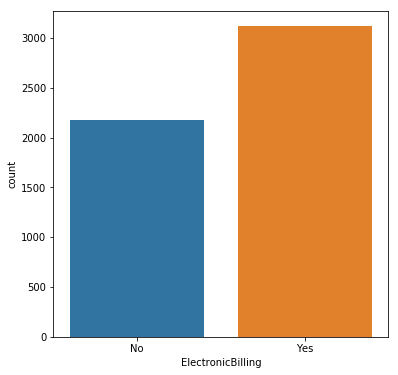

In [13]:
fig, ax = plt.subplots(figsize=(6,6)) 
sns.countplot(x="ElectronicBilling", data=train_account_demo)

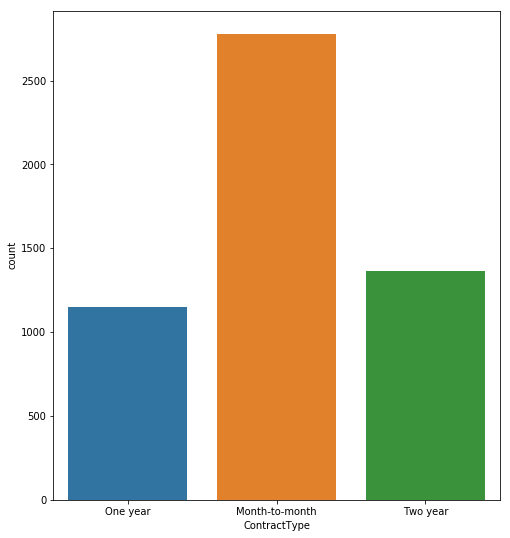

In [14]:
fig, ax = plt.subplots(figsize=(8,9)) 
sns.countplot(x="ContractType", data=train_account_demo)

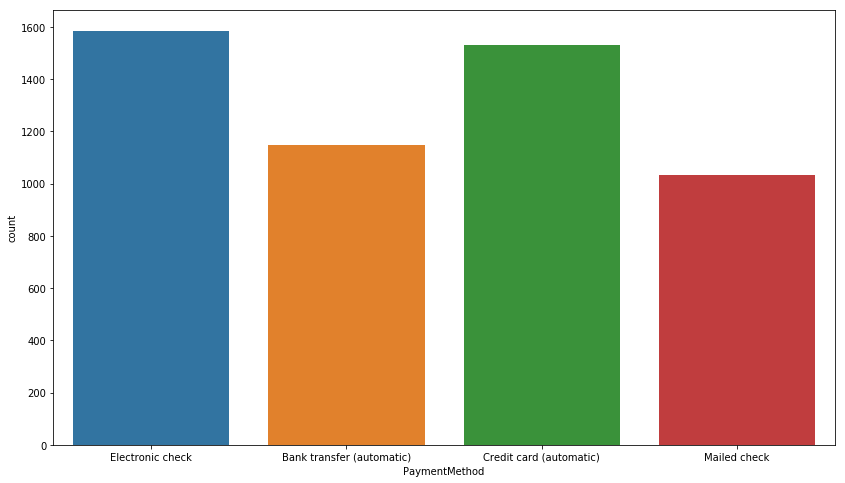

In [15]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.countplot(x="PaymentMethod", data=train_account_demo)

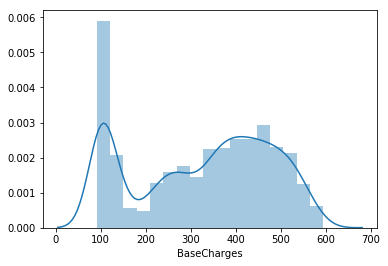

In [16]:
sns.distplot(Train_AccountInfo.BaseCharges)

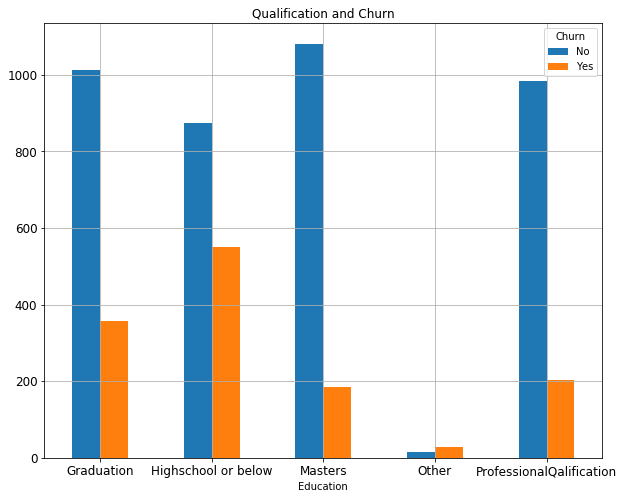

In [17]:
train_account_demo_group = train_account_demo.groupby(['Education','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(10,8),
                                   title='Qualification and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

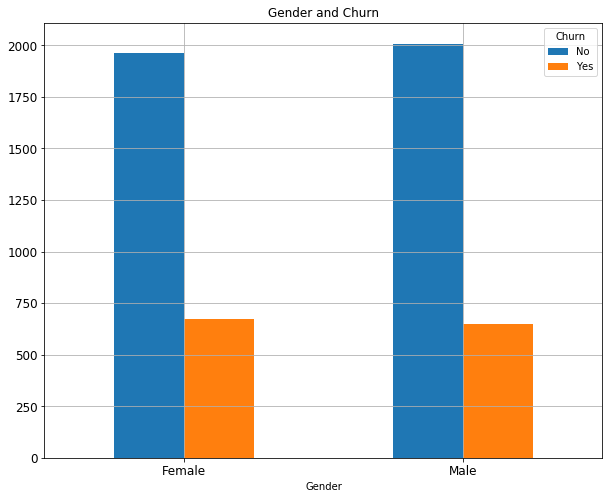

In [18]:
train_account_demo_group = train_account_demo.groupby(['Gender','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(10,8),
                                   title='Gender and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

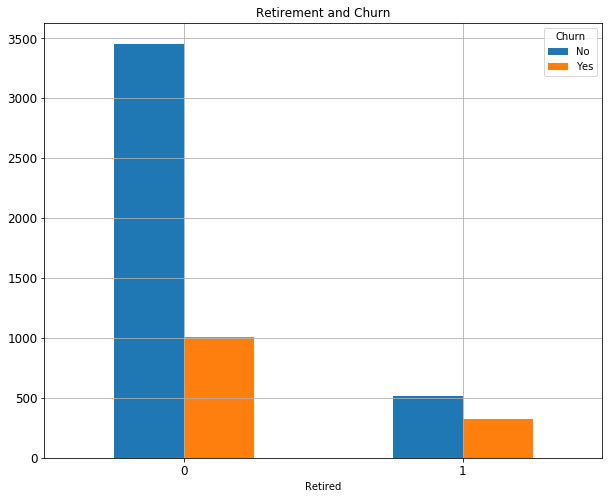

In [19]:
train_account_demo_group = train_account_demo.groupby(['Retired','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(10,8),
                                   title='Retirement and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

In [20]:
#lets do downsampling as the data is highly imbalanced
yes_train = train_account_demo[train_account_demo.Churn == "Yes"]
no_train = train_account_demo[train_account_demo.Churn == "No"]
print(yes_train.shape)
print(no_train.shape)
no_train_1324 = no_train.head(1324)
train_final = yes_train.append(no_train_1324)
print((train_final.shape))
train_final.head()

(1324, 25)
(3974, 25)
(2648, 25)


,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
4,Cust1205,1,1,1,0,0,0,0,0,0,...,ProfessionalQalification,Female,372.5,5-1-2012,372.5,6-Dec-11,Yes,Month-to-month,Electronic check,Yes
12,Cust1213,1,1,1,0,0,0,0,0,0,...,ProfessionalQalification,Female,397.0,5-1-2012,1223.25,7-Oct-11,Yes,Month-to-month,Electronic check,Yes
18,Cust1219,1,1,1,0,0,0,0,0,0,...,Highschool or below,Male,375.0,5-1-2012,1045.5,7-Oct-11,No,Month-to-month,Mailed check,Yes
21,Cust1222,1,1,1,1,1,1,0,0,0,...,Highschool or below,Female,472.0,5-1-2012,8087.5,13-Aug-10,Yes,Month-to-month,Electronic check,Yes
25,Cust1226,1,1,1,0,0,0,0,0,0,...,Highschool or below,Female,371.0,5-1-2012,371,6-Dec-11,Yes,Month-to-month,Electronic check,Yes


## Missing Value Imputation

In [21]:
#Number of missng values in each clumn
train_final.isnull().sum()

CustomerID                               0
TypeOfService_DeviceProtection           0
TypeOfService_HasPhoneService            0
TypeOfService_InternetServiceCategory    0
TypeOfService_StreamingMovies            0
TypeOfService_StreamingTelevision        0
TypeOfService_OnlineBackup               0
TypeOfService_OnlineSecurity             0
TypeOfService_MultipleLines              0
TypeOfService_TechnicalSupport           0
Country                                  0
State                                    0
Retired                                  0
HasPartner                               0
HasDependents                            0
Education                                7
Gender                                   2
BaseCharges                              0
DOC                                      0
TotalCharges                             3
DOE                                      0
ElectronicBilling                        0
ContractType                             2
PaymentMeth

In [22]:
#now lets do missing value analysis
train_final[train_final.Country == "?"]
#there are only two records which have country as ?
#it is evident from state that the country is INDIA
train_final.Country[train_final.Country == "?"] = "India"

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [23]:
#having look at state values
print(train_final.State.value_counts())
train_final[train_final.State == "?"]

Maharashtra    2645
?                 3
Name: State, dtype: int64


,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
2624,Cust3825,1,1,1,1,1,1,0,0,0,...,Graduation,Female,501.25,5-1-2012,11938.75,16-Dec-09,Yes,Month-to-month,Electronic check,Yes
4951,Cust6152,1,1,1,1,0,0,0,0,0,...,Masters,Female,276.00,5-1-2012,2641.75,11-Mar-11,No,Month-to-month,Credit card (automatic),Yes
1495,Cust2696,1,1,1,1,1,0,0,0,0,...,ProfessionalQalification,Male,477.50,5-1-2012,908.25,6-Nov-11,Yes,Month-to-month,Credit card (automatic),No


In [24]:
#we can replace ? with maharastra as the whole data consists only maharashtra
train_final.State[train_final.State == "?"] = "Maharashtra"

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
#as the NA values are less for other columns
#replacing NA with mode for every column
for column in train_final.columns:
    train_final[column].fillna(train_final[column].mode()[0], inplace=True)

In [26]:
#replacing the MISSINGVAL in totalcharges column with the minimum value of the column i.e 100
#print(train_final.TotalCharges.min())
train_final.TotalCharges[train_final.TotalCharges == "MISSINGVAL"] =100
#train_final['TotalCharges'] = train_final['TotalCharges'].map({'MISSINGVAL': 100})

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data Pre-processing

In [27]:
#Now lets convert the dataframe columns into the respective format

categoricalFeatureNames = ["Country","State","Retired","HasPartner","HasDependents","Education", "Gender","ElectronicBilling",
                          "ContractType","PaymentMethod"]

#"Retired","HasPartner","HasDependents","Education","Gender","BaseCharges","TotalCharges",
#                         "ElectronicBilling","ContractType"


numericalFeatureNames = ["TotalCharges","BaseCharges"]
#these are the numerical attributes

#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    train_final[var] = train_final[var].astype("category")
    
#convert the attributes listed above to categorical form
for nar in numericalFeatureNames:
    train_final[nar] = train_final[nar].astype("float64")

In [28]:
train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
y = train_final[['Churn']]

In [29]:
train_final = pd.get_dummies(train_final, prefix=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'],
               columns=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'])

data_final = train_final.drop(['CustomerID','Country','State','DOC','DOE','Churn'], axis=1)

[Text(0,0.5,'Count'),
 Text(0.5,0,'variableTypeariable Type'),
 Text(0.5,1,'Variables DataType Count')]

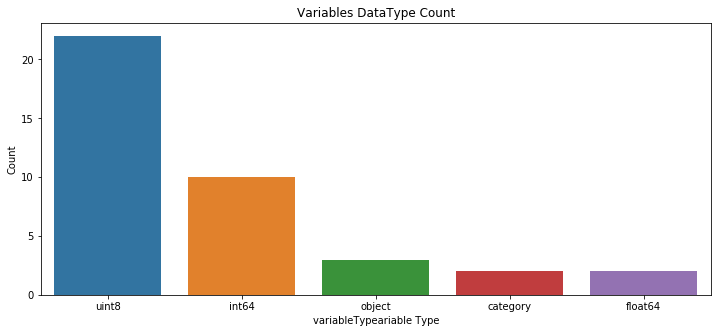

In [30]:
#visualization on the typed of objects in dataframe
dataTypeDf = pd.DataFrame(train_final.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

## Test Data

In [31]:
train = pd.read_csv("Test.csv")
Test_AccountInfo = pd.read_csv("Test_AccountInfo.csv")
Test_Demographics = pd.read_csv("Test_Demographics.csv")
Test_ServicesOptedFor = pd.read_csv("Test_ServicesOptedFor.csv")

In [32]:
#merging two dataframes with customerid attribute
test_test_account= pd.merge(Test_AccountInfo,train,on="CustomerID")
#renaming a column to match
Test_Demographics = Test_Demographics.rename(columns={ "HouseholdID" : "CustomerID"})
#Train_Demographics['HouseholdID'] = "CustomerID"
test_account_demo = pd.merge(Test_Demographics,test_test_account, on="CustomerID")

In [33]:
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "1"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "No internet service"] = "No"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "0"] = "No"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "Fiber optic"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "DSL"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "No phone service"] = "No"

In [34]:
yes_test_service = Test_ServicesOptedFor[Test_ServicesOptedFor.SeviceDetails != 'No']
yes_test_service = yes_test_service.sort_values(by=['TypeOfService'], ascending=['True'])
fff = pd.get_dummies(yes_test_service, prefix=['TypeOfService'],
               columns=['TypeOfService'])

In [35]:
xxx = fff.groupby('CustomerID')['SeviceDetails'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
xxx.columns = xxx.columns.droplevel()
xxx.columns = ['CustomerID','TypeOfService_DeviceProtection', 'TypeOfService_HasPhoneService', 
              'TypeOfService_InternetServiceCategory','TypeOfService_StreamingMovies','TypeOfService_StreamingTelevision',
              'TypeOfService_OnlineBackup','TypeOfService_OnlineSecurity',
             'TypeOfService_MultipleLines',
              'TypeOfService_TechnicalSupport']
xxx = xxx.replace({'Yes': 1, None: 0})
test_account_demo = pd.merge(xxx,test_account_demo, on="CustomerID",how='inner')
test_account_demo.head(2)

,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,HasDependents,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod
0,Cust11201,1,1,1,1,0,0,0,0,0,...,2,Graduation,Male,284.75,5-1-2012,9447.5,21-Mar-09,No,One year,Mailed check
1,Cust11202,1,1,1,1,0,0,0,0,0,...,1,Masters,Male,280.75,5-1-2012,17439.75,2-Dec-06,No,One year,Bank transfer (automatic)


In [36]:
test_account_demo.isnull().sum()

CustomerID                               0
TypeOfService_DeviceProtection           0
TypeOfService_HasPhoneService            0
TypeOfService_InternetServiceCategory    0
TypeOfService_StreamingMovies            0
TypeOfService_StreamingTelevision        0
TypeOfService_OnlineBackup               0
TypeOfService_OnlineSecurity             0
TypeOfService_MultipleLines              0
TypeOfService_TechnicalSupport           0
Country                                  0
State                                    0
Retired                                  0
HasPartner                               0
HasDependents                            0
Education                                4
Gender                                   1
BaseCharges                              0
DOC                                      0
TotalCharges                             0
DOE                                      0
ElectronicBilling                        0
ContractType                             1
PaymentMeth

In [37]:
#as the NA values are less 
#replacing NA with mode for every column
for column in test_account_demo.columns:
    test_account_demo[column].fillna(test_account_demo[column].mode()[0], inplace=True)

In [38]:
test_account_demo.Country[test_account_demo.Country == "?"] = "India"
test_account_demo.TotalCharges[test_account_demo.TotalCharges == "MISSINGVAL"] = 100

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
#Now lets convert the dataframe columns into the respective format

categoricalFeatureNames = ["Country","State","Retired","HasPartner","HasDependents","Education", "Gender","ElectronicBilling",
                          "ContractType","PaymentMethod"]

#"Retired","HasPartner","HasDependents","Education","Gender","BaseCharges","TotalCharges",
#                         "ElectronicBilling","ContractType"


numericalFeatureNames = ["TotalCharges","BaseCharges"]
#these are the numerical attributes

#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    test_account_demo[var] = test_account_demo[var].astype("category")
    
#convert the attributes listed above to categorical form
for nar in numericalFeatureNames:
    test_account_demo[nar] = test_account_demo[nar].astype("float64")

In [40]:
test_account_demo = pd.get_dummies(test_account_demo, prefix=['Retiired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'],
               columns=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'])

test_final = test_account_demo.drop(['CustomerID','Country','State','DOC','DOE'], axis=1)
test_final['PaymentMethod_Credit card (automatic)'] = 0

In [41]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_final, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1986, 33)
(662, 33)
(1986, 1)
(662, 1)


C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Random Forest

In [42]:
#initializing reandom forest
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=600)
RF_clf.fit(X_train, y_train)

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
#predicting on train and test data
#RF_clf.fit(X_train_dtm, y_train)
y_rf_pred_test = RF_clf.predict(X_test)
y_rf_pred_train = RF_clf.predict(X_train)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_rf_pred_test))
#confusion_matrix = confusion_matrix(y_test, y_rf_pred_test)
#print(confusion_matrix)
print(metrics.accuracy_score(y_test, y_rf_pred_test))

             precision    recall  f1-score   support

          0       0.75      0.72      0.73       336
          1       0.72      0.75      0.74       326

avg / total       0.74      0.74      0.74       662

0.7356495468277946


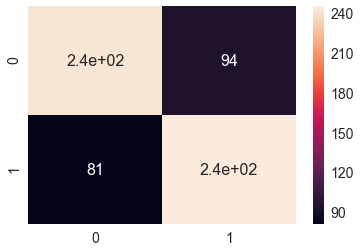

In [44]:
cm = metrics.confusion_matrix(y_test, y_rf_pred_test)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16})# font size

In [45]:
probs_rf = RF_clf.predict_proba(test_final)
probs = probs_rf[:,1]  #taking a column
probs[probs > 0.5] =1  #setting thresholds
probs[probs <= 0.5] = 0
submission = test_account_demo[["CustomerID"]]
submission['Churn'] = probs
submission['Churn'] = submission['Churn'].map({1:"Yes",0:"No"})
#train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
submission.to_csv("predictions.csv",index=False)

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## Logistic Regression

In [46]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
seed=12
logreg = LogisticRegression(C=1, random_state=12, class_weight='balanced')

In [47]:
logreg.fit(X_train, y_train)

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=12,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

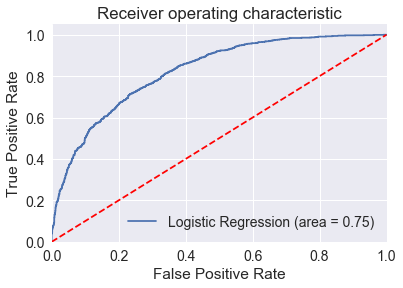

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y, logreg.predict_proba(data_final)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### with 0.5 probability the accuracy is 75% and recall is  75%
#### with 0.35 accuracy is 71  and recall is 85%

In [49]:
y_log_pred_train = logreg.predict(X_train)
ii = logreg.predict_proba(X_test)
probs_log = ii[:,1]  #taking a column
probs_log[probs_log > 0.35] =1  #setting thresholds
probs_log[probs_log <= 0.35] = 0
y_log_pred_test = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, probs_log))
print(classification_report(y_test, probs_log))

0.7175226586102719
             precision    recall  f1-score   support

          0       0.80      0.59      0.68       336
          1       0.67      0.85      0.75       326

avg / total       0.74      0.72      0.71       662



In [50]:
#y_log_pred_test = logreg.predict(test_account_demo)
ii = logreg.predict_proba(test_final)
probs_log = ii[:,1]  #taking a column
probs_log[probs_log > 0.35] =1  #setting thresholds
probs_log[probs_log <= 0.35] = 0
#y_log_pred_test = logreg.predict(X_test)

submission = test_account_demo[["CustomerID"]]
submission['Churn'] = probs_log
submission['Churn'] = submission['Churn'].map({1:"Yes",0:"No"})
#train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
submission.to_csv("predictions_log.csv",index=False)

C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\mohanaditaya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


## Decision Tree

In [51]:
from sklearn import tree
from graphviz import Digraph
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_final, y)

In [52]:
import graphviz 
with open("churn_classifier.txt", "w") as f:
    f = tree.export_graphviz(clf, out_file=f)

In [53]:
# converting into the pdf file
with open("churn_classifier.dot", "w") as f:
    f = tree.export_graphviz(clf, out_file=f)